# Module 2: Data Analysis

## Sprint 3: Statistical Modeling

## Part 5: Red Wine Quality

# Red Wine Quality Project

### Project Goals
* Understand the relationships between the quality of wine and their characteristics
* See which features have the largest correlation with quality and alcohol levels
* Create machine learning model to predict quality from other 11 features
* Create machine learning model to predict alcohol from other 11 features
* Create a Google Data Studio visualization template - <a href="https://datastudio.google.com/reporting/0063c16d-9597-4b69-bb24-9a34571c0a23">Click Here to find my Google Data Studio Project</a>

Data from [Red Wine Quality](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009).

In [351]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [352]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, VectorAssembler, Normalizer, StandardScaler
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from scipy import stats 
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pylab import rcParams
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from math import sqrt

import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import statistics
import pylab as py
import statsmodels.api as sm 

First, I create a spark session

In [353]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Wines") \
    .getOrCreate()

## Reading in the Data Set and Data Cleaning

I read the datasets into pandas and spark dataframes

In [354]:
df_spark = spark.read.csv('winequality-red.csv')
df_spark.persist()
df_pandas = pd.read_csv('winequality-red.csv')

In [355]:
df_spark.head()

Row(_c0='fixed acidity', _c1='volatile acidity', _c2='citric acid', _c3='residual sugar', _c4='chlorides', _c5='free sulfur dioxide', _c6='total sulfur dioxide', _c7='density', _c8='pH', _c9='sulphates', _c10='alcohol', _c11='quality')

In [356]:
df_pandas.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


I check whether there are any null values. There were none null values, therefore, there is nothing to clean.

In [357]:
missing_values_count = df_pandas.isnull().sum()
missing_values_count

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [358]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


## Data Exploration

First, I just want to see how the data look like.

I plot all the features to see their distribution. We can see that none of them follows a standard normal distribution but some of them, such as "fixed acidity", density" or "pH", at leas follow a similar pattern.

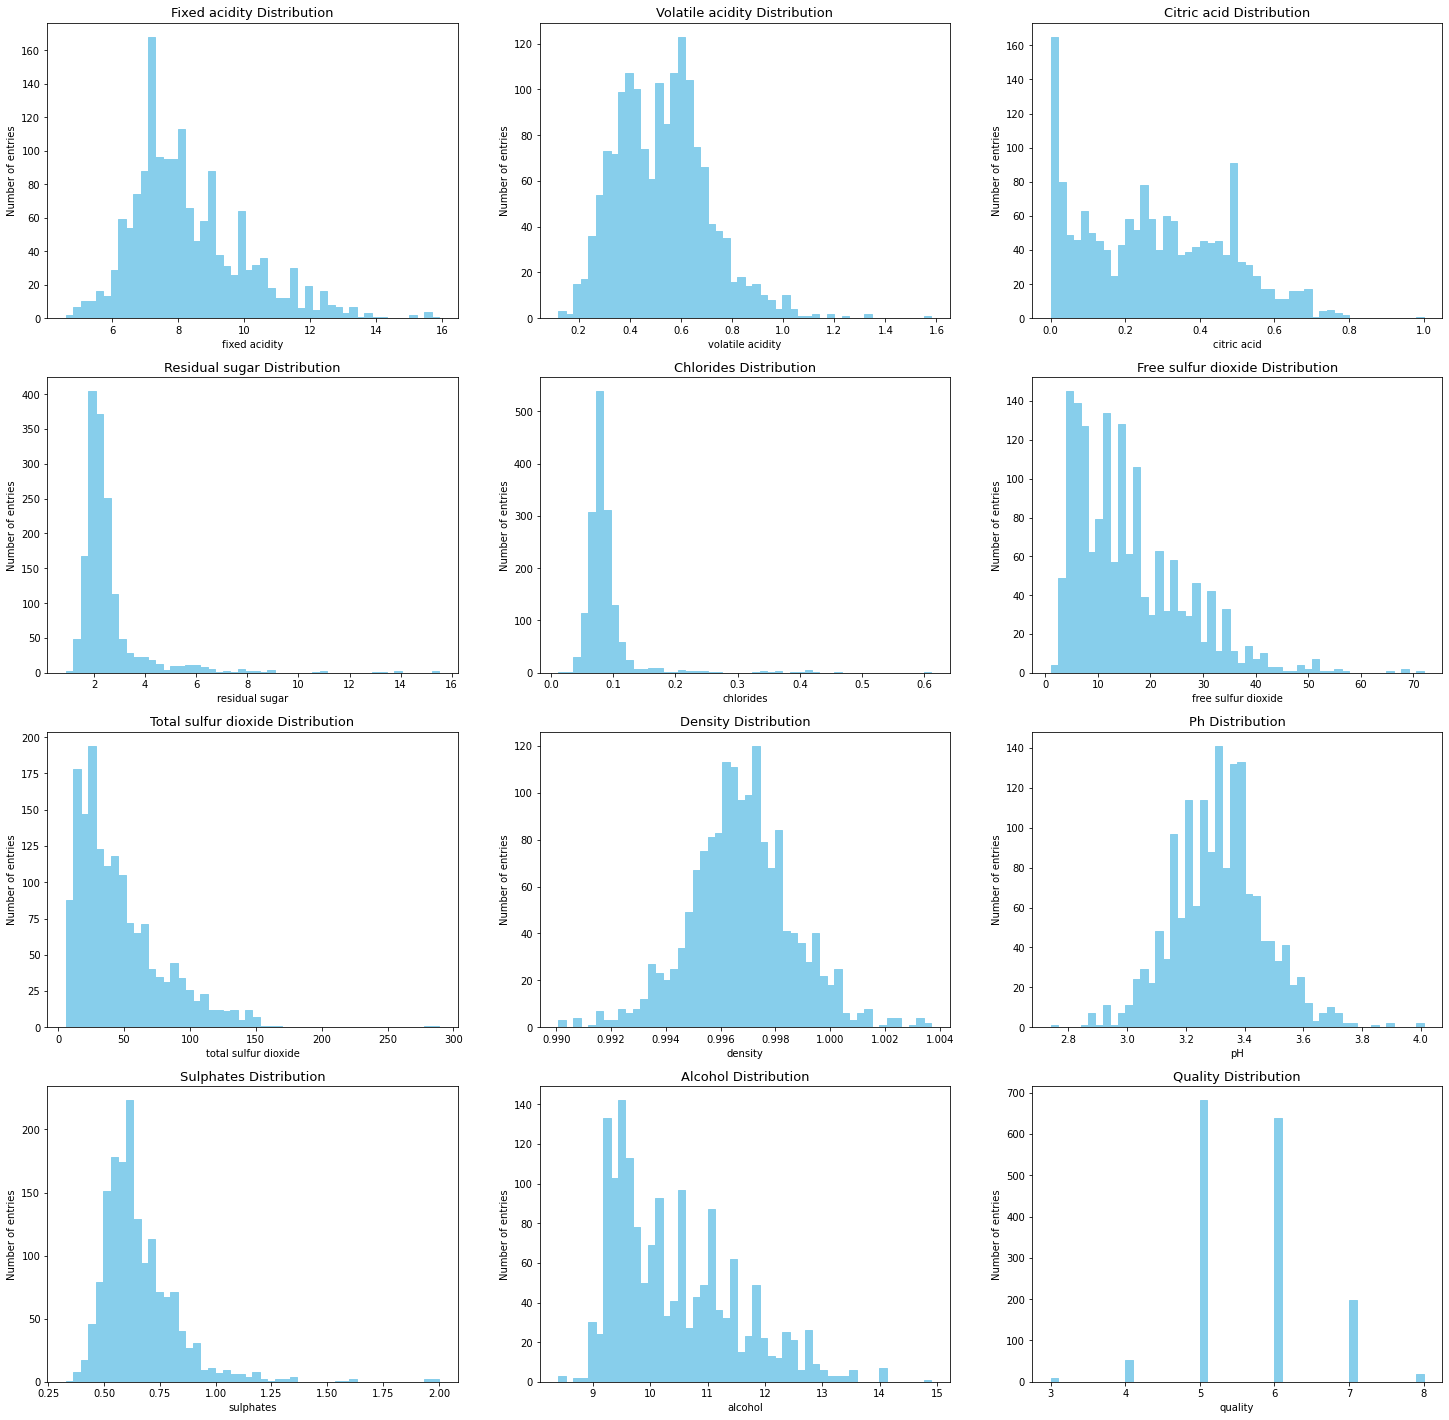

In [359]:
fig, axes = plt.subplots(4, 3, figsize=(25, 25))
i = 0
j = 0

for col in df_pandas.columns:
  if i < 4:
    if j < 3: 

      axes[i][j].hist(df_pandas[col], bins=50, color = "skyblue", ec="skyblue")
      axes[i][j].set_xlabel(col)
      axes[i][j].set_ylabel('Number of entries') 
      axes[i][j].set_title(col.capitalize() + " Distribution", fontsize=13)
      
      j+=1
      if j == 3:
        i+=1
        j=0
         
fig.show()

Since, in the future I will exploring the quality of wines, I wanted to see the quality distribution in the pie chart to get a clearer image of it.

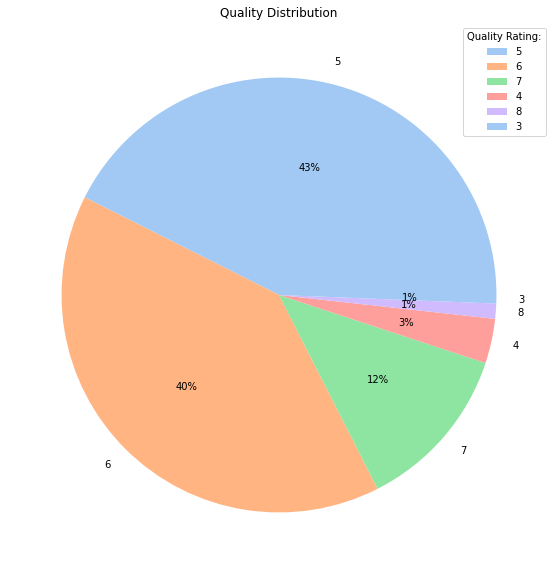

In [360]:
plt.figure(figsize=(20,10))
occ = df_pandas['quality'].value_counts()
colors = sns.color_palette('pastel')[0:5]
 
plt.pie(list(occ), labels=occ.keys(), colors = colors, autopct='%.0f%%')
plt.legend(title = "Quality Rating:")

plt.title("Quality Distribution")
plt.show()

Moreover, I wanted to see the correlation between all of these values. So I plotted a heatmap with all these values.

Text(0.5, 1.0, 'Feature Correlation Heatmap')

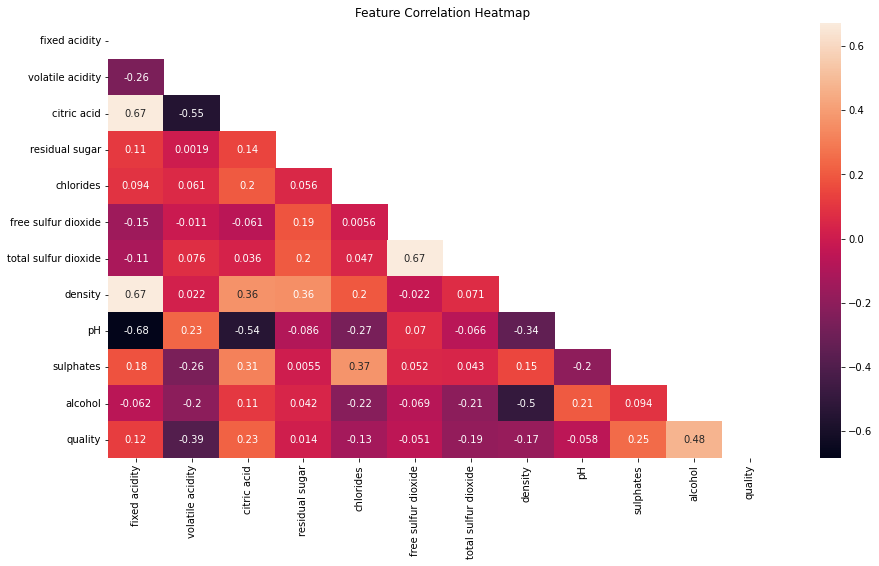

In [361]:
corr= df_pandas.corr() 

matrix = np.triu(corr)

plt.figure(figsize=(15, 8))
sns.heatmap(corr, annot=True, mask=matrix)
plt.title("Feature Correlation Heatmap")

I sorted these correlation pairs to see better which are mostly positively and negatively correlated.

In [362]:
upper_corr_mat = corr.where(
    np.triu(np.ones(corr.shape), k=1).astype(np.bool_))
   
unique_corr_pairs = upper_corr_mat.unstack().dropna()
   
sorted_mat = unique_corr_pairs.sort_values(ascending=False)
print(sorted_mat)

citric acid           fixed acidity          0.671703
density               fixed acidity          0.668047
total sulfur dioxide  free sulfur dioxide    0.667666
quality               alcohol                0.476166
sulphates             chlorides              0.371260
                                               ...   
quality               volatile acidity      -0.390558
alcohol               density               -0.496180
pH                    citric acid           -0.541904
citric acid           volatile acidity      -0.552496
pH                    fixed acidity         -0.682978
Length: 66, dtype: float64


I decided to plot top 4 positively correlated features and top 4 negatively correlated features.

From the scatterplots below, we can clearly see that there is linear relationship between these pairs.

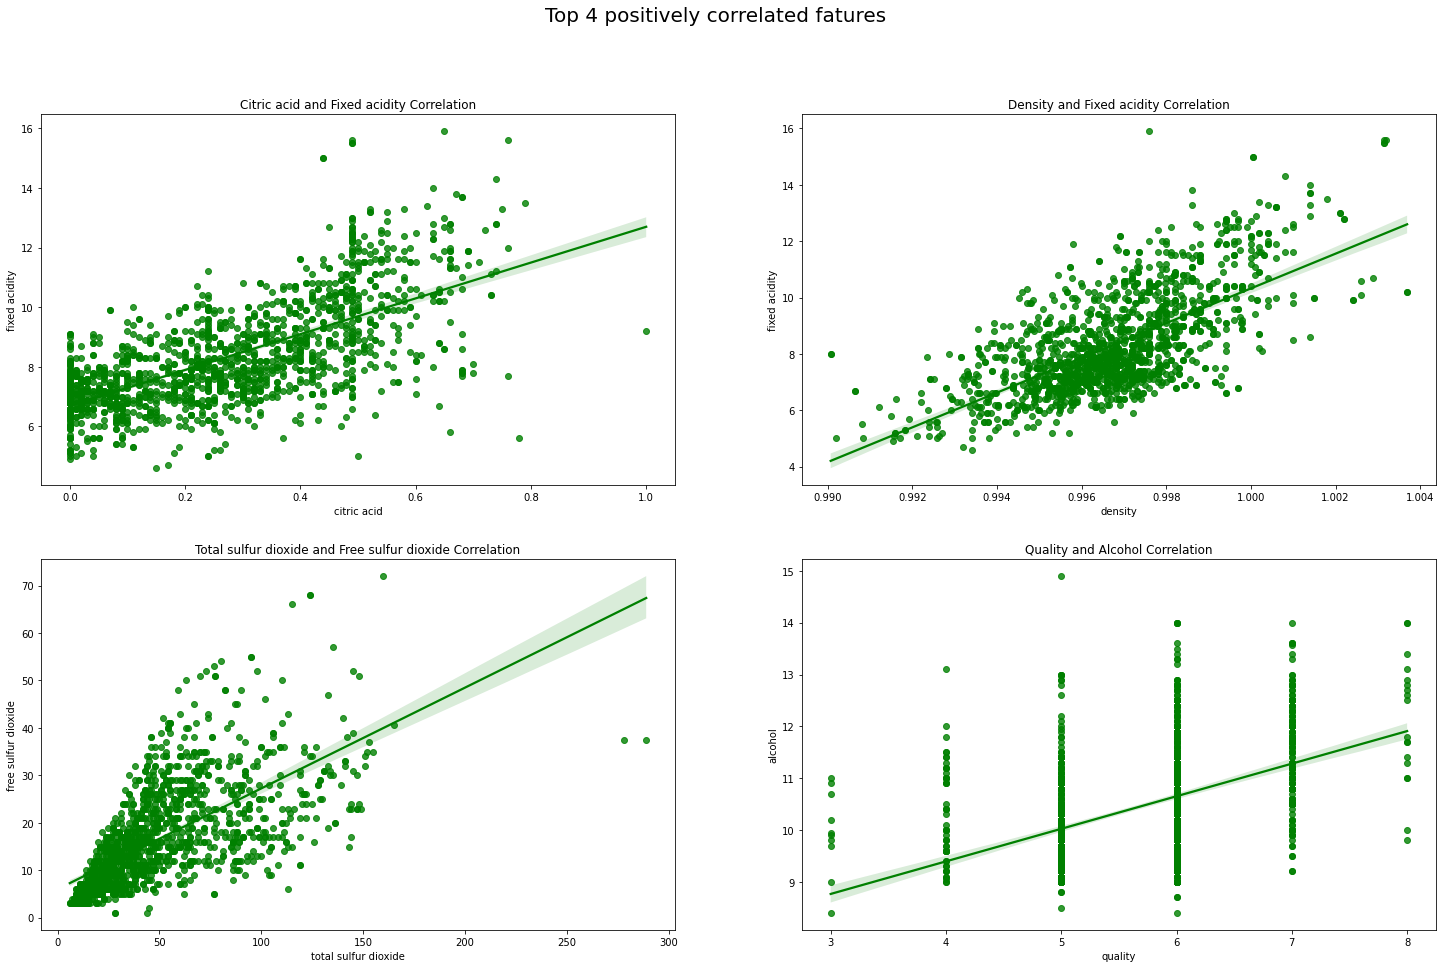

In [363]:
fig, axes = plt.subplots(2, 2, figsize=(25, 15))
i = 0
j = 0

for val in sorted_mat.head(4).keys():
  if i < 2:
    if j < 2:
      sns.regplot(x=val[0], y=val[1], data=df_pandas, marker= 'o', color="g", ax=axes[i][j])
      axes[i][j].set_xlabel(val[0])
      axes[i][j].set_ylabel(val[1])
      axes[i][j].set_title(val[0].capitalize() + " and " + val[1].capitalize() + " Correlation")
      j+=1
      if j == 2:
        i+=1
        j=0
fig.suptitle("Top 4 positively correlated fatures", fontsize=20)
fig.show()

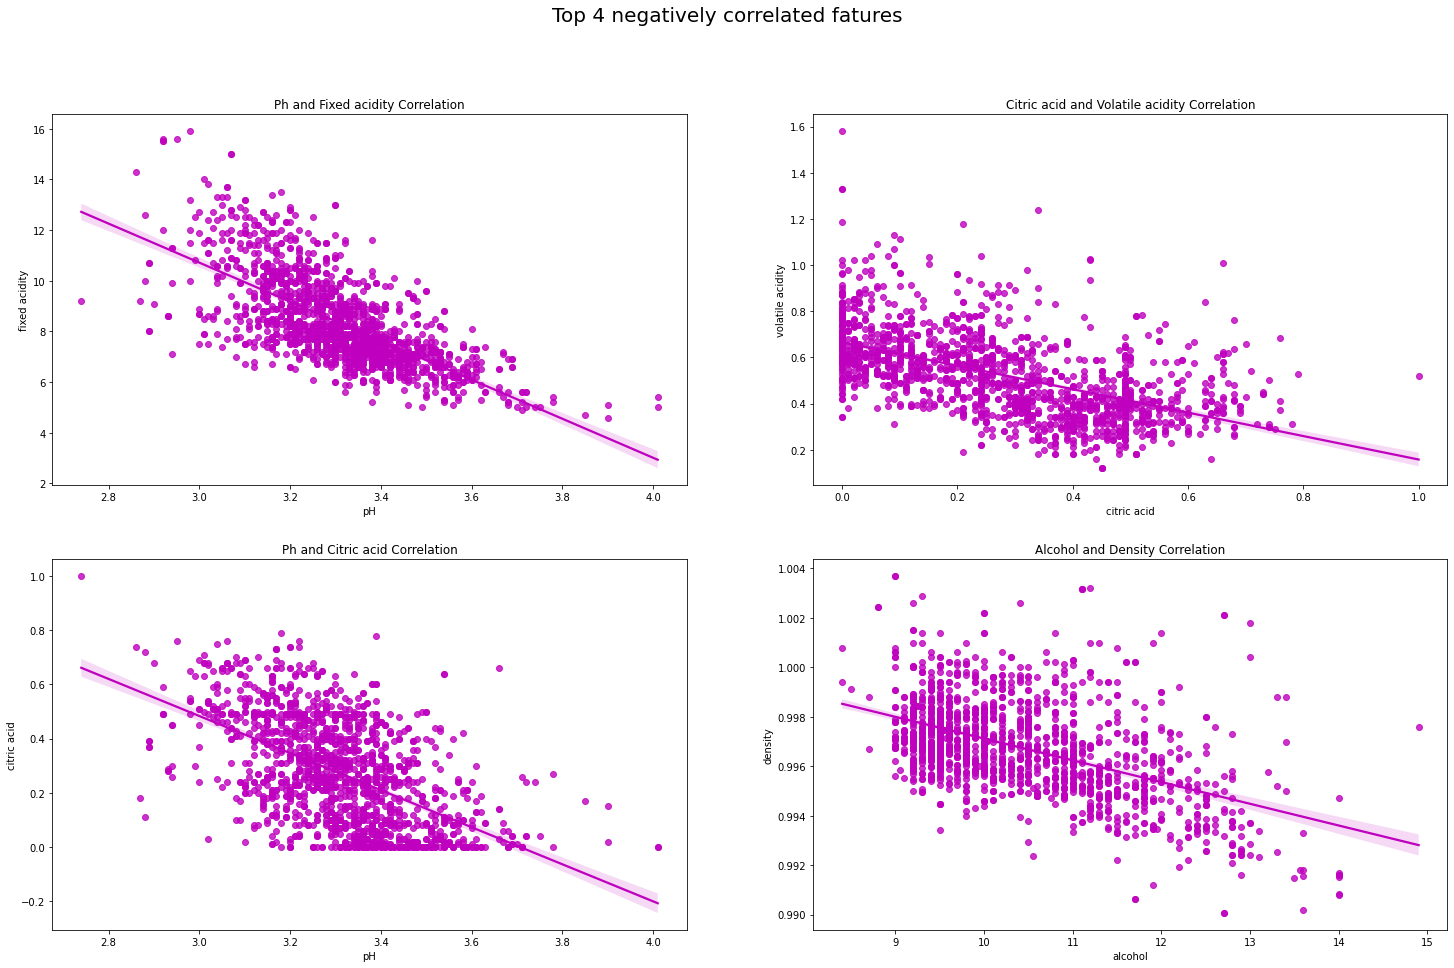

In [364]:
sorted_mat = unique_corr_pairs.sort_values(ascending=True)
fig, axes = plt.subplots(2, 2, figsize=(25, 15))
i = 0
j = 0

for val in sorted_mat.head(4).keys():
  if i < 2:
    if j < 2:
      sns.regplot(x=val[0], y=val[1], data=df_pandas,marker= 'o', color="m", ax=axes[i][j])
      axes[i][j].set_xlabel(val[0])
      axes[i][j].set_ylabel(val[1])
      axes[i][j].set_title(val[0].capitalize() + " and " + val[1].capitalize() + " Correlation")
      j+=1
      if j == 2:
        i+=1
        j=0

fig.suptitle("Top 4 negatively correlated fatures", fontsize=20)
fig.show()

To see a correlation with quality better, I decided to plot get the mean value of each feature by quality rating.

In [365]:
means_by_col_quality = {}
for col in df_pandas.columns:
  means_by_col_quality[col] = df_pandas.groupby(df_pandas["quality"]).agg({col: "mean"})

This gives a bit more in depth understanding about the correlation among these features.

For instance, we can see that the mean value of volatile acid is getting lower when the quality is getting higher. We can see different pattern for citric acid which mean value is getting higher together with the quality. 

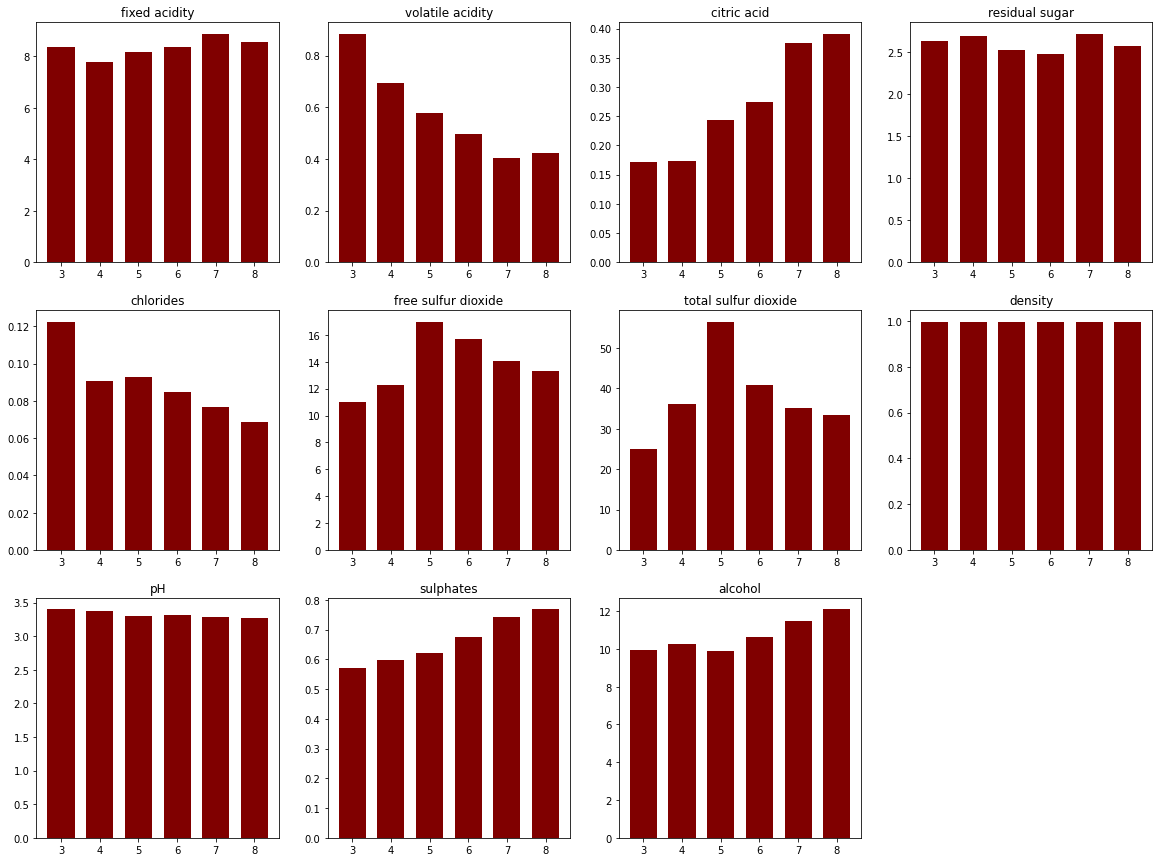

In [366]:
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(nrows=3, ncols=4)

i = 0
j = 0

for key, val in means_by_col_quality.items():
    if key != 'quality': 
      ax = fig.add_subplot(gs[i, j]) 

      j+=1
      if j == 4:
        j = 0
        i += 1
        
      plt.bar(list(val[key].keys()), list(val[key]), color ='maroon',
            width = 0.7)   
      plt.title(key) 
      


## Performing Statistical Inference
I wanted to perform some hypothesis tests for these features and observed patterns.

### Problem Statement 1

**What proportion of wines have high quality?**

* Population here is All Wines
* Parameter of Interest is to calculate a Proportion
* Task is to Construct a 95% Confidence Interval for wines with high quality rating (higher or equal to 7)

In [367]:
df_high_quality_med = df_pandas[df_pandas['quality'] >= 7]

In [368]:
df = df_pandas.copy()
n = df.shape[0] 

print(f"\n95% Confidence Interval for Proportion of wines with quality higher or equal to 7 is: {sm.stats.proportion_confint(len(df_high_quality_med), n)}")


95% Confidence Interval for Proportion of wines with quality higher or equal to 7 is: (0.11892335230093068, 0.15249628497236514)


**Interpretation:**

* With 95% confidence, the population proportion of wines with quality higher or equal to 7 is estimated to be between 11.89% - 15.24%.

### Problem Statement 2

**What proportion of wines have low quality?**

* Population here is All Wines
* Parameter of Interest is to calculate a Proportion
* Task is to Construct a 95% Confidence Interval for wines with low quality rating (lower or equal to 4)

In [369]:
df_low_quality_med = df_pandas[df_pandas['quality'] <= 4]

In [370]:
df = df_pandas.copy()
n = df.shape[0] 

print(f"\n95% Confidence Interval for Proportion of wines with quality lower or equal to 4 is: {sm.stats.proportion_confint(len(df_low_quality_med), n)}")


95% Confidence Interval for Proportion of wines with quality lower or equal to 4 is: (0.029864172904782486, 0.04893507662617436)


**Interpretation:**

* With 95% confidence, the population proportion of wines with quality lower or equal to 4 is estimated to be between 2.98% - 4.89%.

### Problem Statement 3 - Hyphothesis Testing

Considering higher and lower quality wines, do higher quality wines have higher mean citric acid value than lower quality wines?

Let's define a few parameters:

* Population here is a random sample of high and low quality wines

* Our Parameter of Interest is (μ1 − μ2 ): citric acid value

* μ1: Mean citric acid value of wines with high quality

* μ2: Mean citric acid value of wines with low quality

Perform an independent samples test regarding the value for the difference in mean citric acid value between high and low quality wines

H₀: μ1≤μ2

H₁: μ1>μ2

Significance Level - 5%

In [371]:
df_high = df_high_quality_med
df_high = df_high.sample(50)

df_low = df_low_quality_med
df_low = df_low.sample(50)

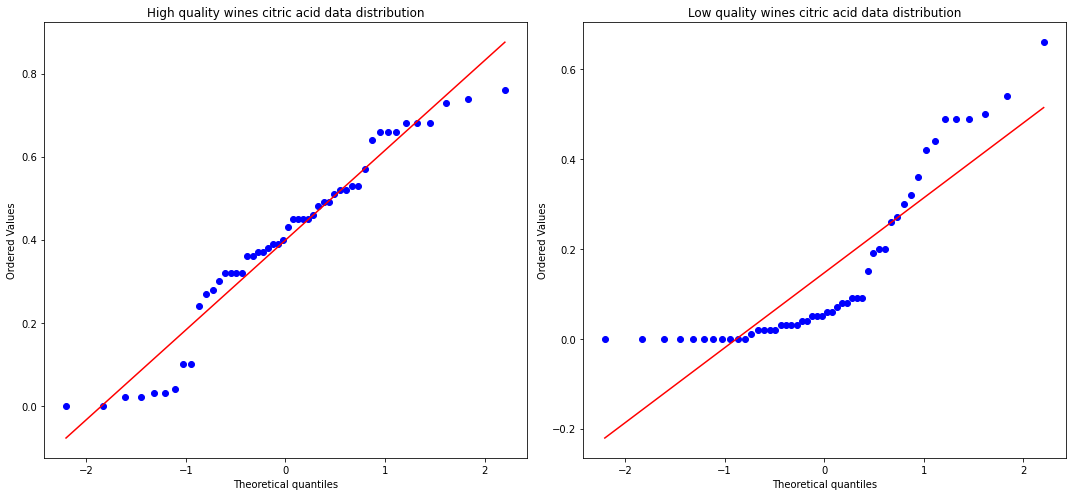

In [372]:
fig2 = plt.figure(figsize=(15, 7))
ax3 = fig2.add_subplot(1, 2, 1)
ax4 = fig2.add_subplot(1, 2, 2)

stats.probplot(df_high['citric acid'], dist='norm', plot=ax3)
ax3.title.set_text('High quality wines citric acid data distribution')

stats.probplot(df_low['citric acid'], dist='norm', plot=ax4)
ax4.title.set_text('Low quality wines citric acid data distribution')

fig2.tight_layout()
plt.show()

In [373]:
ttest,p_value = stats.ttest_ind(df_high['citric acid'], df_low['citric acid'])

print("p value:", p_value)
print(f"since the hypothesis is one sided >> use p_value/2 >> p_value_one_sided: {(p_value/2)}")

if p_value/2 <0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

p value: 8.83369072981834e-09
since the hypothesis is one sided >> use p_value/2 >> p_value_one_sided: 4.41684536490917e-09
Reject null hypothesis


At this significance level, there is enough evidence to conclude that the average citric acid of wines with high quality is higher than the wines with low quality.

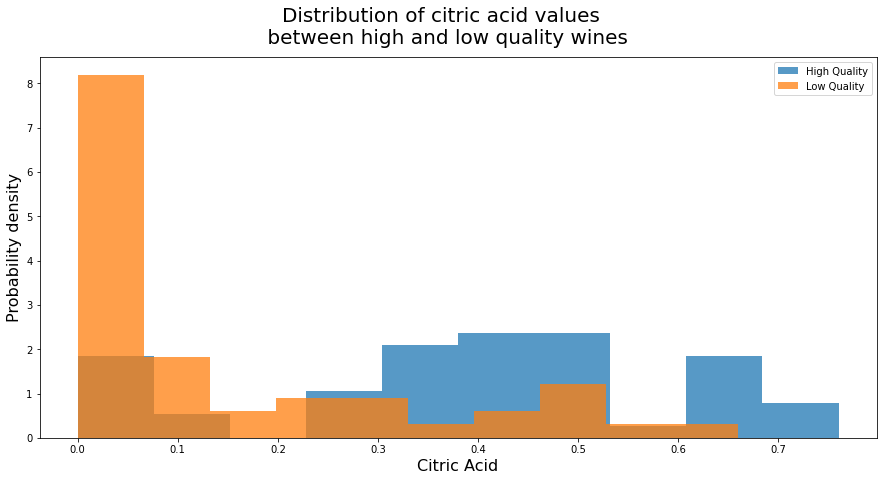

In [374]:
fig = plt.figure(figsize = (15, 7))
ax = fig.add_subplot(111)


p_bp_male = plt.hist(df_high['citric acid'], label= "High Quality",
                     density= True,
                     alpha=0.75)
p_bp_female = plt.hist(df_low['citric acid'], label= "Low Quality",
                       density= True,
                       alpha=0.75)


plt.suptitle("Distribution of citric acid values \n between high and low quality wines", fontsize= 20)
plt.xlabel("Citric Acid", fontsize= 16)
plt.ylabel("Probability density", fontsize= 16)
plt.legend() 

plt.show()

### Problem Statement 4 - Hyphothesis Testing

Considering higher and lower quality wines, do low quality wines have higher mean volatile acidity value than high quality wines?

Let's define a few parameters:

* Population here is a random sample of high and low quality wines

* Our Parameter of Interest is (μ1 − μ2 ): volatile acidity value

* μ1: Mean volatile acidity value of wines with low quality

* μ2: Mean volatile acidity value of wines with high quality

Perform an independent samples test regarding the value for the difference in mean volatile acidity value between high and low quality wines.

H₀: μ1≤μ2

H₁: μ1>μ2

Significance Level - 5%

In [375]:
df_high = df_high_quality_med
df_high = df_high.sample(50)

df_low = df_low_quality_med
df_low = df_low.sample(50)

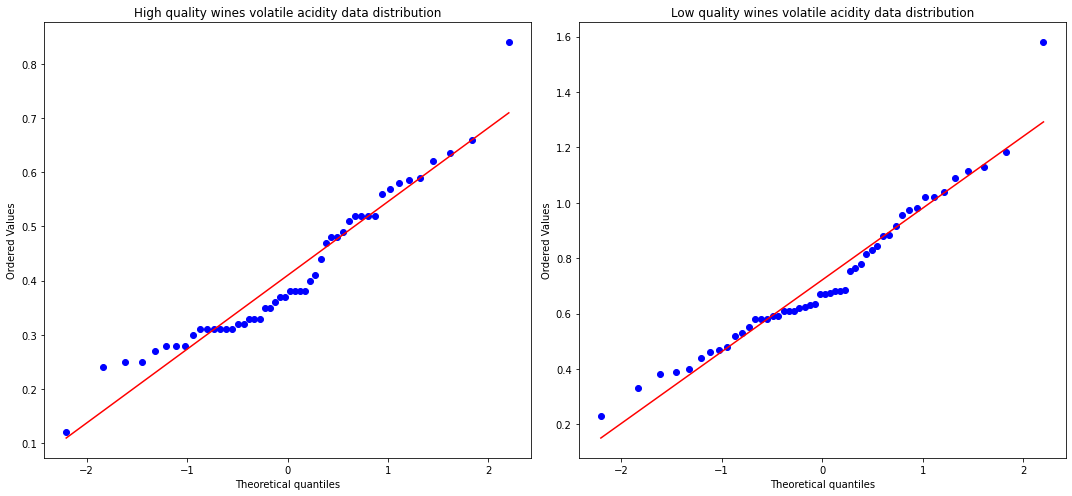

In [376]:
fig2 = plt.figure(figsize=(15, 7))
ax3 = fig2.add_subplot(1, 2, 1)
ax4 = fig2.add_subplot(1, 2, 2)

stats.probplot(df_high['volatile acidity'], dist='norm', plot=ax3)
ax3.title.set_text('High quality wines volatile acidity data distribution')

stats.probplot(df_low['volatile acidity'], dist='norm', plot=ax4)
ax4.title.set_text('Low quality wines volatile acidity data distribution')

fig2.tight_layout()
plt.show()

In [377]:
ttest, p_value = stats.ttest_ind(df_low['volatile acidity'], df_high['volatile acidity'])

print("p value:", p_value)
print("t value:", ttest)

print(f"since the hypothesis is one sided >> use p_value/2 >> p_value_one_sided: {(p_value/2)}")

if p_value/2 <0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

p value: 2.638389766223946e-11
t value: 7.52028845582127
since the hypothesis is one sided >> use p_value/2 >> p_value_one_sided: 1.319194883111973e-11
Reject null hypothesis


At this significance level, there is enough evidence to conclude that the average volatile acid of wines with low quality is higher than the wines with high quality.

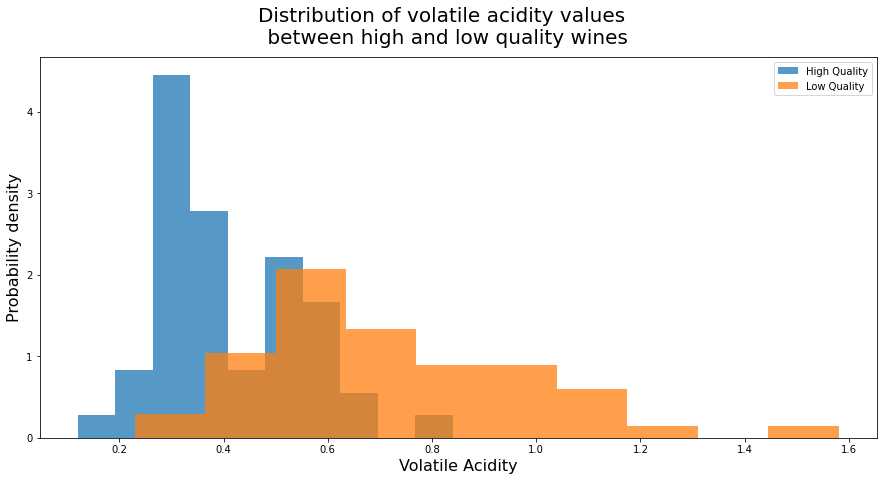

In [378]:
fig = plt.figure(figsize = (15, 7))
ax = fig.add_subplot(111)


p_bp_male = plt.hist(df_high['volatile acidity'], label= "High Quality",
                     density= True,
                     alpha=0.75)
p_bp_female = plt.hist(df_low['volatile acidity'], label= "Low Quality",
                       density= True,
                       alpha=0.75)


plt.suptitle("Distribution of volatile acidity values \n between high and low quality wines", fontsize= 20)
plt.xlabel("Volatile Acidity", fontsize= 16)
plt.ylabel("Probability density", fontsize= 16)
plt.legend() 

plt.show()

### Problem Statement 5 - Hyphothesis Testing

Considering wines with high and low citric acid values, do wines with high citric acid value have higher mean fixed acidity value than low citric acid wines?

Let's define a few parameters:

* Population here is a random sample of high and low citric acidity wines

* Our Parameter of Interest is (μ1 − μ2 ): fixed acidity value

* μ1: Mean fixed acidity value of wines with high citric acidity

* μ2: Mean fixed acidity value of wines with low citric acidity

Perform an independent samples test regarding the value for the difference in mean fixed acidity value between high and low citric acidity wines.

H₀: μ1≤μ2

H₁: μ1>μ2

Significance Level - 5%

In [379]:
median_citric = statistics.median(df_pandas['citric acid'].to_list())
df_higher_citric = df_pandas[df_pandas['citric acid'] > median_citric]
df_lower_citric = df_pandas[df_pandas['citric acid'] < median_citric]

median_citric_higher = statistics.median(df_higher_citric['citric acid'].to_list()) 
median_citric_lower = statistics.median(df_lower_citric['citric acid'].to_list()) 

df_high_citric = df_pandas[df_pandas['citric acid'] > median_citric_higher]
df_high_citric = df_high_citric.sample(100)

df_low_citric = df_pandas[df_pandas['citric acid'] < median_citric_lower]
df_low_citric = df_low_citric.sample(100)

In [380]:
print("High citric acid value:", median_citric_higher)
print("Low citric acid value:", median_citric_lower)

High citric acid value: 0.43
Low citric acid value: 0.09


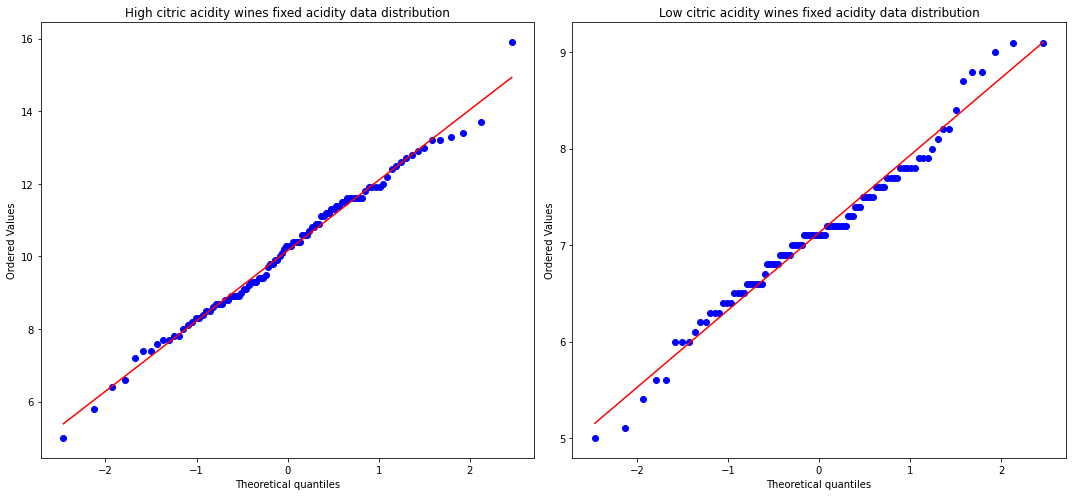

In [381]:
fig2 = plt.figure(figsize=(15, 7))
ax3 = fig2.add_subplot(1, 2, 1)
ax4 = fig2.add_subplot(1, 2, 2)

stats.probplot(df_high_citric['fixed acidity'], dist='norm', plot=ax3)
ax3.title.set_text('High citric acidity wines fixed acidity data distribution')

stats.probplot(df_low_citric['fixed acidity'], dist='norm', plot=ax4)
ax4.title.set_text('Low citric acidity wines fixed acidity data distribution')

fig2.tight_layout()
plt.show()

In [382]:
ttest, p_value = stats.ttest_ind(df_high_citric['fixed acidity'], df_low_citric['fixed acidity'])

print("p value:", p_value)
print("t value:", ttest)

print(f"since the hypothesis is one sided >> use p_value/2 >> p_value_one_sided: {(p_value/2)}")

if p_value/2 <0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

p value: 2.770596546478303e-33
t value: 14.61105898874531
since the hypothesis is one sided >> use p_value/2 >> p_value_one_sided: 1.3852982732391515e-33
Reject null hypothesis


At this significance level, there is enough evidence to conclude that the average fixed acidity of wines with high citric acid value is higher than the wines with with low citric acid value.

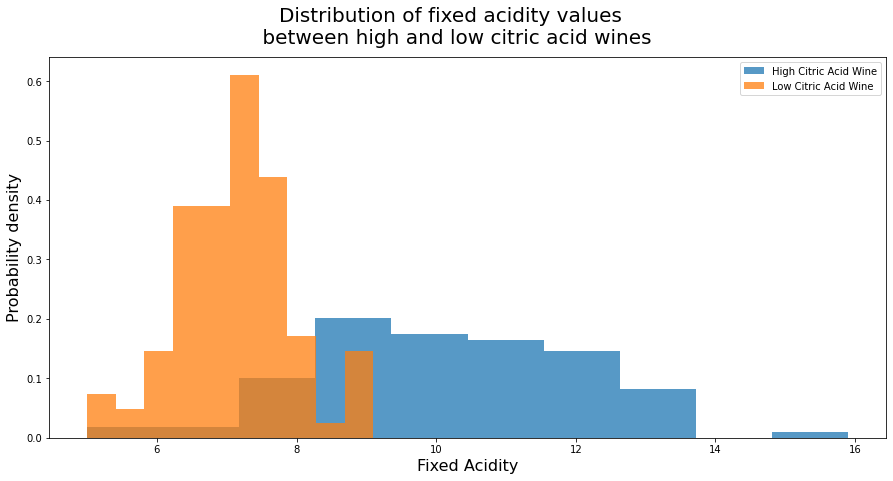

In [383]:
fig = plt.figure(figsize = (15, 7))
ax = fig.add_subplot(111)


p_bp_male = plt.hist(df_high_citric['fixed acidity'], label= "High Citric Acid Wine",
                     density= True,
                     alpha=0.75)
p_bp_female = plt.hist(df_low_citric['fixed acidity'], label= "Low Citric Acid Wine",
                       density= True,
                       alpha=0.75)


plt.suptitle("Distribution of fixed acidity values \n between high and low citric acid wines", fontsize= 20)
plt.xlabel("Fixed Acidity", fontsize= 16)
plt.ylabel("Probability density", fontsize= 16)
plt.legend() 

plt.show()

### Problem Statement 6 - Hyphothesis Testing

Considering wines with high and low PH values, do wines with high fixed acidity value have lower mean PH value than low fixed acidity wines?

Let's define a few parameters:

* Population here is a random sample of high and low citric acidity wines

* Our Parameter of Interest is (μ1 − μ2 ): fixed acidity value

* μ1: Mean fixed acidity value of wines with low PH value

* μ2: Mean fixed acidity value of wines with high PH value

Perform an independent samples test regarding the value for the difference in mean fixed acidity value between high and low PH wines.

H₀: μ1≤μ2

H₁: μ1>μ2

Significance Level - 5%

In [384]:
median_ph = statistics.median(df_pandas['pH'].to_list())
df_higher_ph = df_pandas[df_pandas['pH'] > median_ph]
df_lower_ph = df_pandas[df_pandas['pH'] < median_ph]

median_ph_higher = statistics.median(df_higher_ph['pH'].to_list()) 
median_ph_lower = statistics.median(df_lower_ph['pH'].to_list()) 

df_high_ph = df_pandas[df_pandas['pH'] > median_ph_higher]
df_high_ph = df_high_ph.sample(100)

df_low_ph = df_pandas[df_pandas['pH'] < median_ph_lower]
df_low_ph = df_low_ph.sample(100)

In [385]:
print("High pH value:", median_ph_higher)
print("Low pH value:", median_ph_lower)

High pH value: 3.4
Low pH value: 3.21


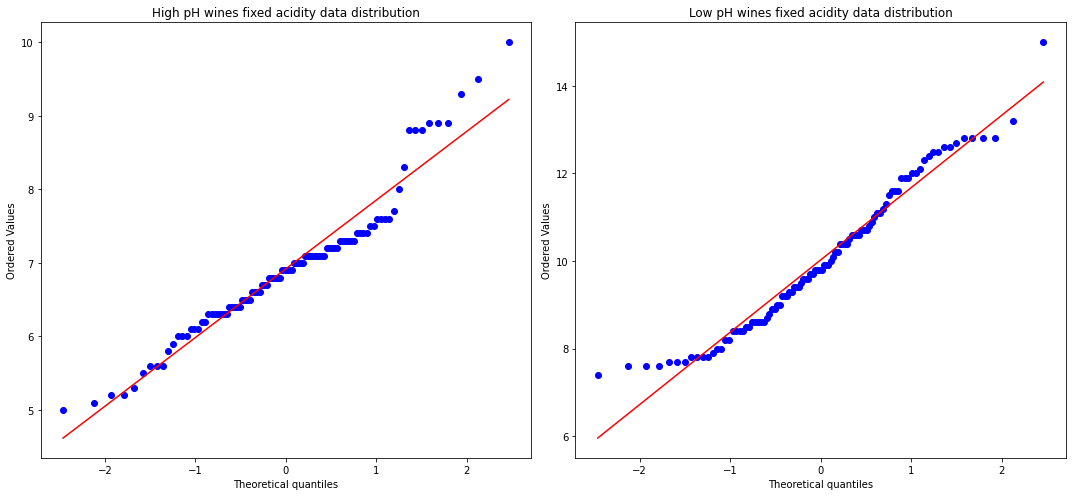

In [386]:
fig2 = plt.figure(figsize=(15, 7))
ax3 = fig2.add_subplot(1, 2, 1)
ax4 = fig2.add_subplot(1, 2, 2)

stats.probplot(df_high_ph['fixed acidity'], dist='norm', plot=ax3)
ax3.title.set_text('High pH wines fixed acidity data distribution')

stats.probplot(df_low_ph['fixed acidity'], dist='norm', plot=ax4)
ax4.title.set_text('Low pH wines fixed acidity data distribution')

fig2.tight_layout()
plt.show()

In [387]:
ttest, p_value = stats.ttest_ind(df_low_ph['fixed acidity'], df_high_ph['fixed acidity'])

print("p value:", p_value)
print("t value:", ttest)

print(f"since the hypothesis is one sided >> use p_value/2 >> p_value_one_sided: {(p_value/2)}")

if p_value/2 <0.05:
    print("Reject null hypothesis")
else:
    print("Fail to reject null hypothesis")

p value: 2.432708769141889e-38
t value: 16.266913376132596
since the hypothesis is one sided >> use p_value/2 >> p_value_one_sided: 1.2163543845709444e-38
Reject null hypothesis


At this significance level, there is enough evidence to conclude that the average fixed acidity of wines with low PH value is higher than the wines with with high PH value.

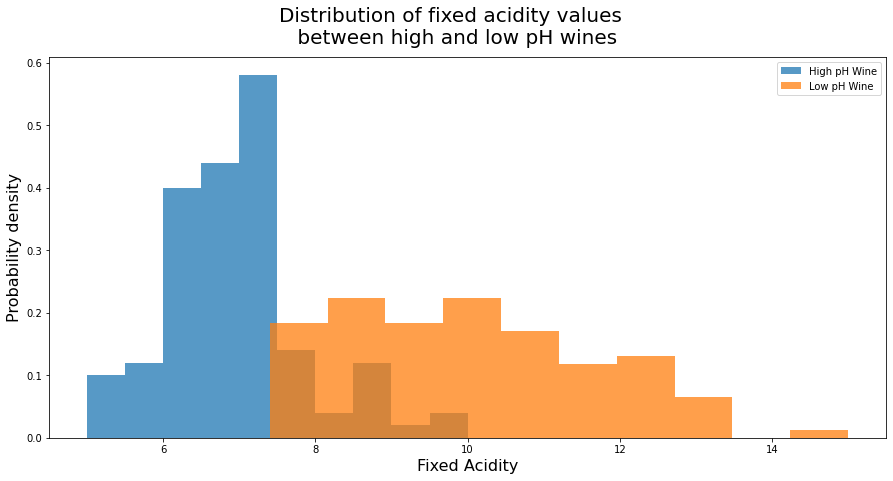

In [388]:
fig = plt.figure(figsize = (15, 7))
ax = fig.add_subplot(111)


p_bp_male = plt.hist(df_high_ph['fixed acidity'], label= "High pH Wine",
                     density= True,
                     alpha=0.75)
p_bp_female = plt.hist(df_low_ph['fixed acidity'], label= "Low pH Wine",
                       density= True,
                       alpha=0.75)


plt.suptitle("Distribution of fixed acidity values \n between high and low pH wines", fontsize= 20)
plt.xlabel("Fixed Acidity", fontsize= 16)
plt.ylabel("Probability density", fontsize= 16)
plt.legend() 

plt.show()

## From Categorical Quality to Numerical

In [389]:
categorical_quality = df_pandas['quality']
df_pandas = pd.get_dummies(df_pandas, columns=["quality"]) 
df_pandas['quality'] = categorical_quality
df_pandas.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,0,1,0,0,0,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,0,1,0,0,0,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,0,1,0,0,0,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0,0,0,1,0,0,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,0,1,0,0,0,5


## Performing Machine Learning Tasks

### Linear machine learning models to predict the quality
Apply linear machine learning models to predict the quality column using the other 11 features.

In [390]:
df_spark=spark.createDataFrame(df_pandas)   

In [391]:
vectorAssembler = VectorAssembler(inputCols=["fixed acidity", "volatile acidity", "citric acid",
               "residual sugar", "chlorides", "free sulfur dioxide",
               "total sulfur dioxide", "density", "pH", "sulphates",
               "alcohol"],
    outputCol="features")
df_spark = vectorAssembler.transform(df_spark)
df_spark = df_spark.select(['features', 'quality'])
df_spark.show(3)

+--------------------+-------+
|            features|quality|
+--------------------+-------+
|[7.4,0.7,0.0,1.9,...|      5|
|[7.8,0.88,0.0,2.6...|      5|
|[7.8,0.76,0.04,2....|      5|
+--------------------+-------+
only showing top 3 rows



In [392]:
train_df, test_df = df_spark.randomSplit([0.8, 0.2], seed=42) 

In [393]:
scaler = Normalizer(inputCol="features", outputCol="features_normalized")
train_df = scaler.transform(train_df)
test_df = scaler.transform(test_df)

In [394]:
'''
Baseline Model to compare real model with dummy one
'''
def print_baseline_model_info(X_train, X_test, y_train, y_true, strategy):
    dummy_clf = DummyRegressor(strategy=strategy)
    dummy_clf.fit(X_train, y_train)
    y_pred = dummy_clf.predict(X_test)
    y_pred_train = dummy_clf.predict(X_train)
    y_true = [float(i) for i in y_true]
  
    print("Dummy Model Evaluation")
    print("R2: %f" % r2_score(y_true, y_pred))
    print("MAE: %f" % mean_absolute_error(y_true, y_pred))
    print("MSE: %f" % mean_squared_error(y_true, y_pred)) 

In [395]:
X_train = [len(x.features) for x in train_df.collect()]
X_test = [len(x.features) for x in test_df.collect()]
y_train = [x.quality for x in train_df.collect()]
y_test = [x.quality for x in test_df.collect()]
 
print_baseline_model_info(X_train, X_test, y_train, y_test, 'mean')

Dummy Model Evaluation
R2: -0.000462
MAE: 0.696386
MSE: 0.700277


In [396]:
lr = LinearRegression(featuresCol='features_normalized', labelCol='quality', maxIter=100)
lr_model = lr.fit(train_df) 

* R2 score - the value of the r squared score is 1, it means that the model is perfect and if its value is 0, it means that the model will perform badly on an unseen dataset. Therefore, we can see that the model is not really good.
* MAE (mean absolute error) - finding the absolute difference between the predicted value and the actual value, summing all these values and finding their average. The predictions were off from the mean by an average of 0.62.
* MSE (Mean Squared Error) represents the difference between the original and predicted values extracted by squared the average difference over the data set.

In [397]:
trainingSummary = lr_model.summary
print("Train Data Evaluation")
print("R2: %f" % trainingSummary.r2)
print("MAE: %f" % trainingSummary.meanAbsoluteError)
print("MSE: %f" % trainingSummary.meanSquaredError)

Train Data Evaluation
R2: 0.357422
MAE: 0.510601
MSE: 0.412339


In [398]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction", "quality", "features_normalized").show(8)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="quality", metricName="r2")

print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+-----------------+-------+--------------------+
|       prediction|quality| features_normalized|
+-----------------+-------+--------------------+
| 6.42185160430387|      7|[0.10307470207033...|
|5.611810350651448|      6|[0.09857786858857...|
|5.307073455654754|      5|[0.04899063230423...|
| 5.25643902094789|      5|[0.09832672281730...|
|5.778395666083907|      7|[0.05779847251824...|
|5.781246674762508|      7|[0.08812999919405...|
|5.140195311467016|      5|[0.05748339101351...|
| 6.19983952454229|      5|[0.16139835437483...|
+-----------------+-------+--------------------+
only showing top 8 rows

R Squared (R2) on test data = 0.365262


In [399]:
test_result = lr_model.evaluate(test_df)
print("Test Data Evaluation")
print("R2: %f" % test_result.r2)
print("MAE: %f" % test_result.meanAbsoluteError)
print("MSE: %f" % test_result.meanSquaredError)

Test Data Evaluation
R2: 0.365262
MAE: 0.521247
MSE: 0.444287


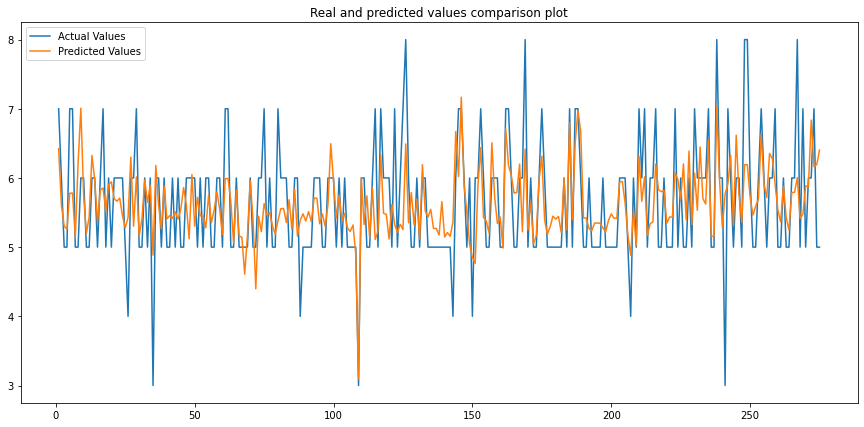

In [400]:
results = lr_predictions.select("prediction", "quality").collect()
predicted_vals = [x.prediction for x in results]
actual_vals = [x.quality for x in results]
  
plt.figure(figsize=(15, 7))
sns.lineplot(x=range(1, len(actual_vals)+1), y=actual_vals, label="Actual Values", legend='brief')
sns.lineplot(x=range(1, len(predicted_vals)+1), y=predicted_vals, label="Predicted Values", legend='brief')
 
plt.title("Real and predicted values comparison plot")
plt.show()

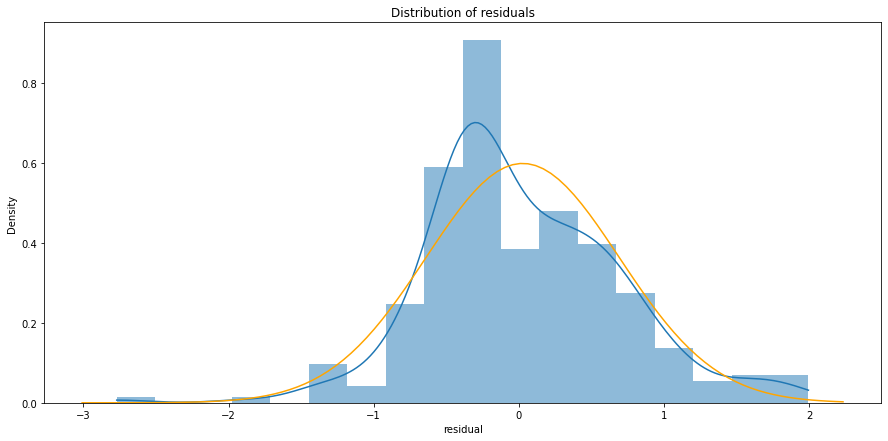

In [401]:
residuals = [x.residuals for x in test_result.residuals.collect()]
 
mu, std = stats.norm.fit(residuals)
mu, std

fig, ax = plt.subplots(figsize = (15, 7))
# plot the residuals
sns.histplot(x=residuals, ax=ax, stat="density", linewidth=0, kde=True)
ax.set(title="Distribution of residuals", xlabel="residual")

# plot corresponding normal curve
xmin, xmax = plt.xlim() # the maximum x values from the histogram above
x = np.linspace(xmin, xmax, 100) # generate some x values
p = stats.norm.pdf(x, mu, std) # calculate the y values for the normal curve
sns.lineplot(x=x, y=p, color="orange", ax=ax)
plt.show()

A residual is a measure of how far away a point is vertically from the regression line.

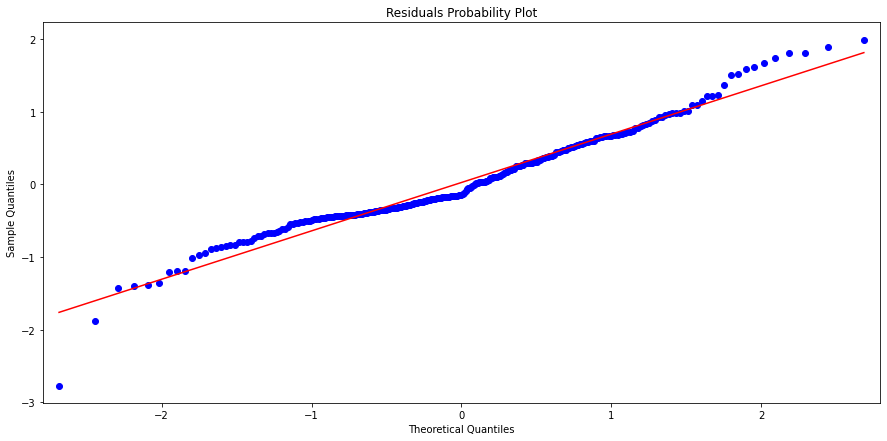

In [402]:
rcParams['figure.figsize'] = 15, 7
sm.qqplot(np.array(residuals), line='s')
plt.title("Residuals Probability Plot")
py.show()

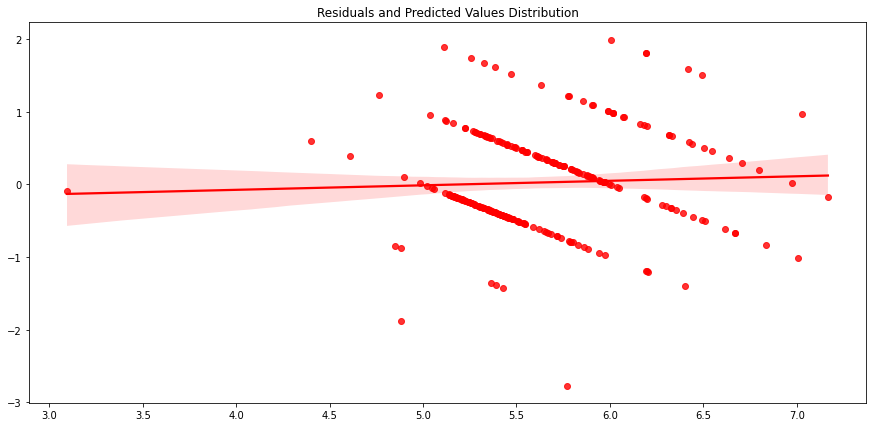

In [403]:
sns.regplot(x=predicted_vals, y=residuals, data=None, scatter=True,
            color='red')
plt.title("Residuals and Predicted Values Distribution")
plt.show()

### Linear machine learning models to predict the alcohol 
Apply linear machine learning models to predict the alcohol column using the other 11 features.

In [404]:
df_spark=spark.createDataFrame(df_pandas)   

In [405]:
vectorAssembler = VectorAssembler(inputCols=["fixed acidity", "volatile acidity", "citric acid",
               "residual sugar", "chlorides", "free sulfur dioxide",
               "total sulfur dioxide", "density", "pH", "sulphates",
               "quality_3", "quality_4", "quality_5", "quality_6", "quality_7", "quality_8"],
    outputCol="features")

df_spark = vectorAssembler.transform(df_spark)
df_spark = df_spark.select(['features', 'alcohol'])
df_spark.show(3)

+--------------------+-------+
|            features|alcohol|
+--------------------+-------+
|[7.4,0.7,0.0,1.9,...|    9.4|
|[7.8,0.88,0.0,2.6...|    9.8|
|[7.8,0.76,0.04,2....|    9.8|
+--------------------+-------+
only showing top 3 rows



In [406]:
train_df, test_df = df_spark.randomSplit([0.8, 0.2], seed=42) 

In [407]:
scaler = Normalizer(inputCol="features", outputCol="features_normalized")
train_df = scaler.transform(train_df)
test_df = scaler.transform(test_df)

In [408]:
lr = LinearRegression(featuresCol='features', labelCol='alcohol', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df) 

In [409]:
trainingSummary = lr_model.summary
print("Train Data Evaluation")
print("R2: %f" % trainingSummary.r2)
print("MAE: %f" % trainingSummary.meanAbsoluteError)
print("MSE: %f" % trainingSummary.meanSquaredError)

Train Data Evaluation
R2: 0.310528
MAE: 0.729825
MSE: 0.784890


In [410]:
train_df.describe().show() 

+-------+------------------+
|summary|           alcohol|
+-------+------------------+
|  count|              1324|
|   mean|10.428033736153052|
| stddev|1.0673578491932723|
|    min|               8.4|
|    max|              14.0|
+-------+------------------+



In [411]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction", "alcohol", "features").show(8)

lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="alcohol", metricName="r2")

print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+------------------+------------------+--------------------+
|        prediction|           alcohol|            features|
+------------------+------------------+--------------------+
|11.450390140105924|              14.0|[4.9,0.42,0.0,2.1...|
|11.077082594145907|              12.5|[5.0,0.74,0.0,1.2...|
|10.678026477326227|              11.5|[5.0,1.04,0.24,1....|
|10.369630773885433|               9.2|[5.2,0.32,0.25,1....|
|11.412846315339237|13.566666666666698|[5.3,0.47,0.11,2....|
|11.025340409711504|              12.3|[5.4,0.42,0.27,2....|
|10.409856300421211|               9.2|[5.6,0.31,0.37,1....|
|10.787976249857252|              12.9|[5.6,0.605,0.05,2...|
+------------------+------------------+--------------------+
only showing top 8 rows

R Squared (R2) on test data = 0.259234


In [412]:
test_result = lr_model.evaluate(test_df)
print("Test Data Evaluation")
print("R2: %f" % test_result.r2)
print("MAE: %f" % test_result.meanAbsoluteError)
print("MSE: %f" % test_result.meanSquaredError)

Test Data Evaluation
R2: 0.259234
MAE: 0.700638
MSE: 0.827871


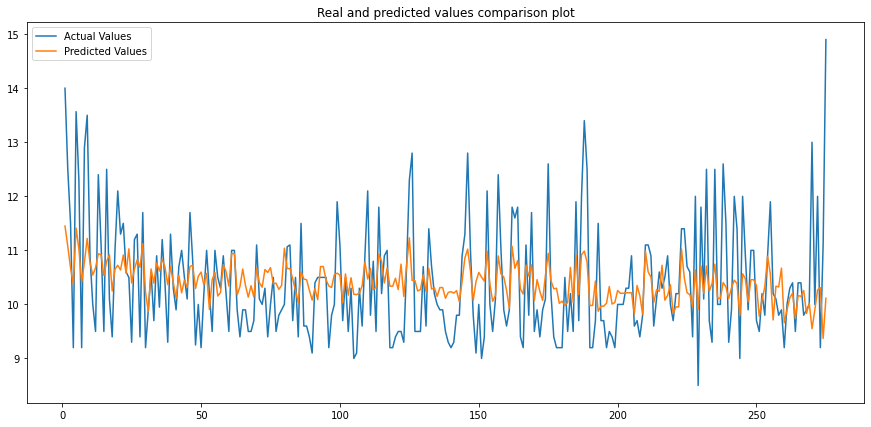

In [413]:
results = lr_predictions.select("prediction", "alcohol").collect()
predicted_vals = [x.prediction for x in results]
actual_vals = [x.alcohol for x in results]
  
plt.figure(figsize=(15, 7))
sns.lineplot(x=range(1, len(actual_vals)+1), y=actual_vals, label="Actual Values", legend='brief')
sns.lineplot(x=range(1, len(predicted_vals)+1), y=predicted_vals, label="Predicted Values", legend='brief')
 
plt.title("Real and predicted values comparison plot")
plt.show()

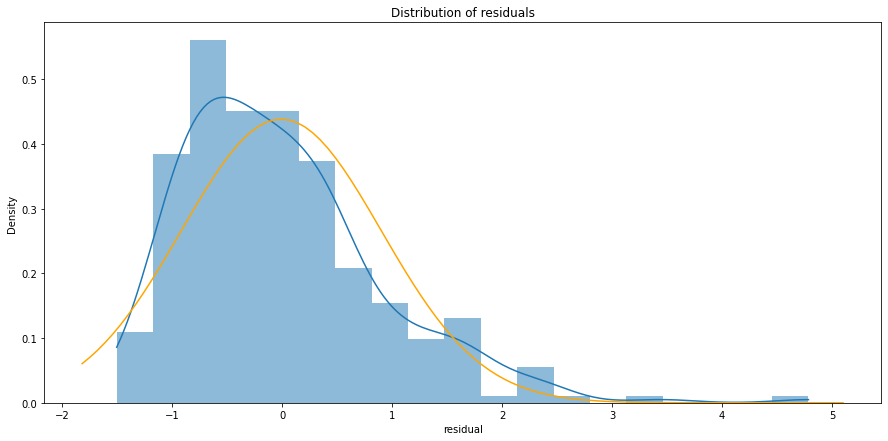

In [414]:
residuals = [x.residuals for x in test_result.residuals.collect()]
 
mu, std = stats.norm.fit(residuals)
mu, std

fig, ax = plt.subplots(figsize = (15, 7))
# plot the residuals
sns.histplot(x=residuals, ax=ax, stat="density", linewidth=0, kde=True)
ax.set(title="Distribution of residuals", xlabel="residual")

# plot corresponding normal curve
xmin, xmax = plt.xlim() # the maximum x values from the histogram above
x = np.linspace(xmin, xmax, 100) # generate some x values
p = stats.norm.pdf(x, mu, std) # calculate the y values for the normal curve
sns.lineplot(x=x, y=p, color="orange", ax=ax)
plt.show()

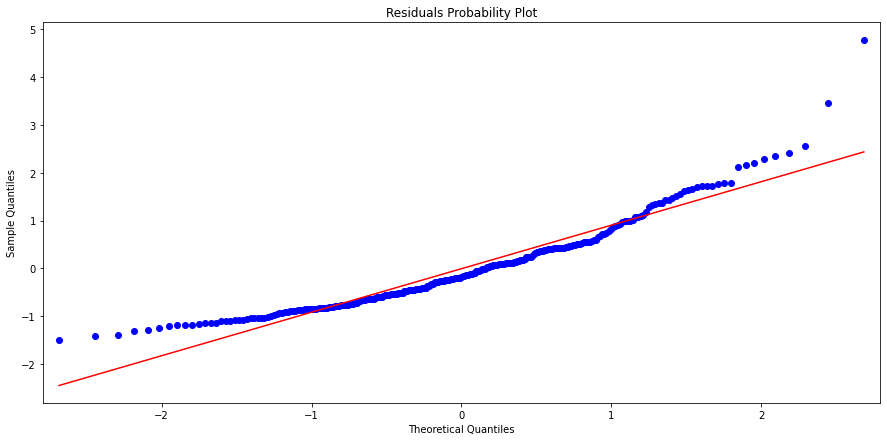

In [415]:
rcParams['figure.figsize'] = 15, 7
sm.qqplot(np.array(residuals), line='s')
plt.title("Residuals Probability Plot")
py.show()

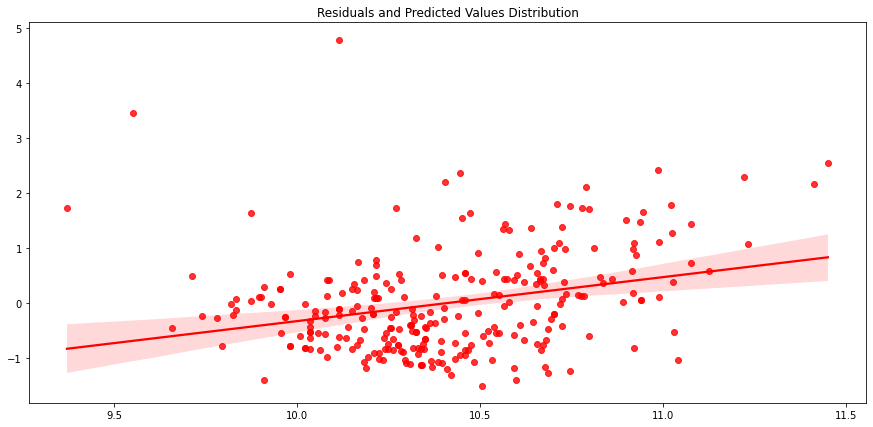

In [416]:
sns.regplot(x=predicted_vals, y=residuals, data=None, scatter=True,
            color='red')
plt.title("Residuals and Predicted Values Distribution")
plt.show()

## Results
* With hypothesis testing we have concluded that there is enough evidence to conclude that the average fixed acidity of wines with high citric acid value is higher than the wines with with low citric acid value.
* With hypothesis testing we have concluded that there is enough evidence to conclude that the average fixed acidity of wines with low PH value is higher than the wines with with high PH value.
* There are a lot of correlations in the dataset, however, using all of them for the Linear Regression model might be excessive. Therefore, this might have caused not very good models.
* Model which predicts quality with other 11 features is better than the one which predicts alcohol level.

#### Observations about features:
* Lower volatile acidity can indicate higher wine quality.
* Higher citric acid concentration might indicate higher quality.
* Wines with higher quality have more sulphates in it on average.
* Wines with higher quality have less chlorides in it on average.
* Higher alcohol levels were observed in wines with higher quality.
* The lower the density, the higher the alcohol level.